# Electronic Convergence
In contrast to simulation with interatomic potentials which only consider the interaction of atoms, density functional theory (DFT) leverages the density of electrons to determine the forces between atoms and the energy of a simulation cell. Consequently, the careful threatment of the electronic convergence is essential for high precision DFT calculation. In the following the [VASP](https://www.vasp.at) DFT code is used in combination with [pyiron.org](https://pyiron.org) workflow framework to develop a practical understanding of DFT simulation. 

pyiron is available as open-source software and can be installed from the `conda` package manager using:
```
conda install -c conda-forge pyiron_atomistics pyiron-data nglview
```
This command installs the `pyiron_atomistics` package and the `nglview` package to visualise atomistic structures in the jupyter environment. 

In addition, to the `Project` object from `pyiron_atomistics` also the numerical library `numpy` and the visualization library `matplotlib` are imported. The `Project` object behaves like a folder on the file system and adds the capability to create other `pyiron` objects like atomistic structures and simulation jobs. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from pyiron_atomistics import Project

## Calculation

As a first step the `vasp` folder is created using the `Project` object. To have a clean start all calculations in this folder are removed using the `remove_jobs()` function. This is typically not necessary, but it is a helpful command to restart fresh.

In [2]:
pr = Project("vasp")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

In the second step, the primitive atomistic structure for Aluminium (Al) is created. In pyiron this is achieved using the `create.structure.ase.bulk()` function of the `Project` object. To help with interactive development, python provides `tab` completion, so by typing `pr.create.` and pressing `tab` you get a list of available objects which can be created from the `Project`. The advantage of creating these objects from the `Project` object is that the path of the `Project` object is then automatically used for data storage, so the `structure` object directly knows it should write any data to the `path` of the `Project` object. You can print the path of the `Project` object using `pr.path`. 

In [3]:
structure_Al = pr.create.structure.ase.bulk("Al")

Depending on your version of Jupyterlab the `tab` based completion for multiple levels, might be disabled for security reasons, as it could be used to execute code before you pressing `shift+enter`. To enable this functionality again you can use:
```
%config IPCompleter.greedy=True
```
Just copy the like to a cell at the beginning of your Jupyter notebook to enable `tab` based completion without any limits. 

For validation the structure object can be visualized using the `plot3d()` function, which internally uses `nglview` to visualise the atomic structure in the Jupyter notebook. 

In [4]:
structure_Al.plot3d()

NGLWidget()

After the creation of the `structure` object, the VASP `job` object can be created using the same `create()` function of the project object. After the creation of the `job` object, the `structure` object is assigned. Followed by the specification of the k-point mesh using the `set_kpoints()` function, the energy cutoff using the `set_encut()` function and the electronic convergence criteria using the `set_convergence_precision()` function. Finally, the computational resources can be assigned. In this case only a single computational core is selected, but typically such a calculation would be submitted to a high performance computing (HPC) cluster. Up to this point no data was written to the file system. Only when the `run()` function of the `job` object is executed `pyiron` writes the input files for the VASP DFT simulation code, calls the simulation code and parses the output of the calculation.  

In [5]:
job_Al = pr.create.job.Vasp("vasp")

# select structure to compute 
job_Al.structure = structure_Al

# specify precision of the DFT calculation 
job_Al.set_kpoints([2,2,2])
job_Al.set_encut(300)
job_Al.set_convergence_precision(electronic_energy=10**-10)

# define computational resources 
job_Al.server.cores = 1

# execute simulation 
job_Al.run()

The job vasp was saved and received the ID: 23313931


## Analysis 
When the calculation is successfully completed, the next step is to analyse the calculation results. Just like the setup of the calculation, in `pyiron` all these steps can be executed directly from the Jupyter notebook. In this way the Jupyter notebook behaves like a lab book in an experimental lab combining both, the input of the calculation and the output of the calculation in one document. To achieve reproducibility of these simulation protocols, the scientific input and the technical inputs are separated. For this demonstration the technical configuration, was installed in the beginning with the `pyiron-data` package, it contains the link to the SPHInX simulation code installed via conda, to allow new users to start right away. The scientific input is written in this notebook. In this way the notebook can be copied from one `pyiron` installation to another and still works as expected. 

In addition to the separation of technical and scientific configuration, it is typically also helpful to separate the setup of the calculation and the analysis. Especially in cases when the individual calculation take multiple days or even weeks. In this example the cells below can be executed independent of the calculation section. As a first step the previous calculation named `"vasp"` is reloaded using the `load()` function of the `Project` object and the electronic energy is aggegated in the `eng_lst`. 

In [6]:
pr = Project("vasp")
eng_lst = np.array(pr.load("vasp")["output/generic/dft/scf_energy_free"]).flatten()

It is important to mention that both the commands to setup the VASP calculation, as well as the commands used to analyse the output of the VASP calculation are independent of the specific simulation code. Basically, the same workflow would work with the other DFT codes, as `pyiron` provides an abstract generic interface to different DFT codes to unify their interfaces.

The electronic energy is plotted over the number of electronic steps with the energy on the y-axis and the number of electronic steps on the x-axis.

Text(0, 0.5, 'Energy (eV)')

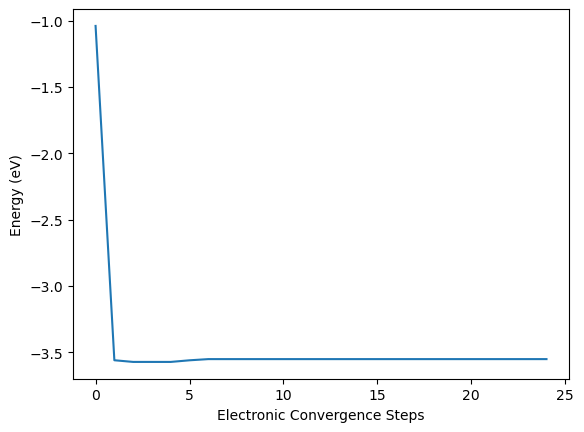

In [7]:
plt.plot(eng_lst)
plt.xlabel("Electronic Convergence Steps")
plt.ylabel("Energy (eV)")

The calculation seems to be converged after the first electronic step with only minimal changes afterwards. But this impression is caused by the misleading representation of the data. If we subtract the full converged energy at the last electronic steps `eng_lst[-1]` from all other energies and take the absolute of this difference `np.abs()` then we can plot is on a semi-logarithmic scale. This highlights the logarithmic convergence of the electronic structure, nearly linear with the number of steps in the semi-logarithmic plot. 

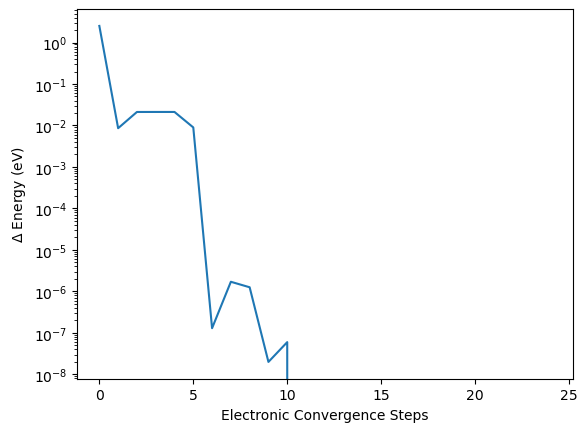

In [8]:
plt.plot(np.abs(eng_lst-eng_lst[-1]))
plt.xlabel("Electronic Convergence Steps")
plt.ylabel("$\Delta$ Energy (eV)")
plt.yscale("log")

This example demonstrates that determening if a calculation is converged or not always depends on the convergence goal. A convergence of $10^{-3}$ is already achived at the second electronic step while a convergence of $10^{-7}$ in this case requires three electronic steps and so on. 

## Job Management
In the background `pyiron` uses an Structured Query Language (SQL) database to keep track of the currently running and completed calculation. This has the advantage that old calculation can be reloaded using the `load()` function of the `Project` object. Still it can also lead to confusion in the beginning when users try to update the input parameter of an existing calculation. The easiest way is to delete all calculation in a given `Project` using the `remove_jobs()` function as demonstrated in the beginning. Alternatively the `job` object can be reloaded and removed individually by calling the `remove()` function on the `job` object. Or to compare multiple calculation the user can simply choose a `job_name` different from `"spx"`. To get an overview or all `job` objects in a given project `pyiron` provides the `job_table()` function of the `Project` object. 

In [9]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,23313931,finished,Al,vasp,/vasp,/cmmc/u/,janj/notebooks/2024/2023-08-26-debug-vasp/vasp/,2024-09-05 15:34:45.386969,2024-09-05 15:34:46.943127,1.0,janj@cmti001#1,Vasp,5.4.4,None,None


## Conclusion
While for bulk structures electronic convergence is quickly achieved, for more complex chemical structures, surfaces or defects electronic convergence can be much more challenging. So it is important to carefully check the electronic convergence for every calculation.